This is a modeling phase for the FakeNews project

Initial classifier has shown a good result with ExtraTreesClassifier (done by pycaret
LGBM seems to be somewhat better though
Here we will be training and tuning this model

In [5]:
# Kill the warnings:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
import optuna  # pip install optuna

In [7]:
from optuna.integration import LightGBMPruningCallback

In [19]:
# Main Dependencies:
import numpy as np # linear algebra
import pandas as pd # data processing

from lightgbm import LGBMClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import nltk
from textblob import TextBlob, Word
import config

# Statistics imports:
from statistics import mean
import scipy.stats
from scipy.stats import pearsonr,spearmanr

import matplotlib.pyplot as plt

In [ ]:
# some necessary actions:

In [60]:
Emotions = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']
wordsData = pd.read_excel(config.wordsData_url, index_col=0)
wordsData = wordsData[wordsData.columns.intersection(['English Word']+[emotion for emotion in Emotions])]

--- Feature Constructors:

In [49]:
def feature_wordsCount(df_row, Sentence, df):
    # count the unique words in the Sentence and calculate the ratio
    uniqueWords = len(set(Sentence.words))
    totalWords = len((Sentence.words))
    df.at[df_row,'uniqe_words_ratio']=uniqueWords/totalWords

In [50]:
def feature_nounPolarity(df_row, Sentence, df):
    # Add feature for sum of polarity index into the dataset
    # df_row is an index of the row in the dataframe
    #Sentence = TextBlob(fake_news_full_df['text'][df_row]).correct()
    try:
        df.at[df_row,'nounPolarity'] = mean([TextBlob(nounS).sentiment.polarity for nounS in Sentence.noun_phrases])
    except:
        df.at[df_row,'nounPolarity'] = 0 # No nouns found

In [51]:
def feature_nounSubjectivity(df_row, Sentence, df):
    # Add feature for sum of subjectivity index into the dataset
    # df_row is an index of the row in the dataframe
    #Sentence = TextBlob(fake_news_full_df['text'][df_row]).correct()
    try:
        df.at[df_row,'nounSubjectivity'] = mean([TextBlob(nounS).sentiment.subjectivity for nounS in Sentence.noun_phrases])
    except:
        df.at[df_row,'nounSubjectivity'] = 0 # No nouns found

In [52]:
def feature_sentenceSentiment(df_row, Sentence, df):
    # Entire phrase sentiment analysis
    # df_row is an index of the row in the dataframe
    #Sentence = TextBlob(fake_news_full_df['text'][df_row]).correct()
    polarity, subjectivity = Sentence.sentiment
    df.at[df_row,'sentencePolarity'] = polarity
    df.at[df_row,'sentenceSubjectivity'] = subjectivity
    df.at[df_row,'meanPolarity_per_sentence'] = mean([sentence.polarity for sentence in Sentence.sentences])
    df.at[df_row,'meanSubjetivity_per_sentence'] = mean([sentence.subjectivity for sentence in Sentence.sentences])

In [53]:
def feature_Emotions(df_row, Sentence, df):
    # Insert the emotional count per words into dataset
    # df_row is an index of the row in the dataframe
    # WordsData is the English dataset, one-hot-encoded for emotions

    # Reset emotions for the selected row
    for emotion in Emotions:
        df.at[df_row,emotion]=0

    for word in [Word(word).singularize().lemmatize() for word in Sentence.words if word in wordsData.index]:
        try:
            for emotion in set(wordsData.columns[(wordsData[wordsData.index == word].values == 1)[0]].tolist()):
                df.at[df_row,emotion]+=1
        except:
            pass # no emotonal load for that specific word

In [54]:
def frequency_Analysis(df_row, Sentence, df):
    # Emotional load converting to frequency and amplitude
    # df_row is an index of the row in the dataframe

    #Sentence = TextBlob(fake_news_full_df['text'][df_row]).correct()
    data1 = np.array([sentence.polarity for sentence in Sentence.sentences]) # Sentence polarity
    data2 = np.array([sentence.subjectivity for sentence in Sentence.sentences]) # Sentence subjectivity
    sentence_timing = [len(sentence.words) for sentence in Sentence.sentences] # Sentence timing

    #Frequency Analysis:
    ps1 = np.abs(np.fft.fft(data1))**2
    ps2 = np.abs(np.fft.fft(data2))**2

    time_step = 1 / np.average(sentence_timing)
    freqs1 = np.fft.fftfreq(data1.size, time_step)
    freqs2 = np.fft.fftfreq(data2.size, time_step)

    MaxPolarityFrequency = round(max(freqs1),2) # Feature
    MaxSubjectivityFrequency = round(max(freqs2),2) # Feature

    df.at[df_row,'MaxPolarityFrequency'] = MaxPolarityFrequency
    df.at[df_row,'MaxSubjectivityFrequency'] = MaxSubjectivityFrequency

In [55]:
def correlation_and_entropy(df_row,Sentence,df):
    # Test for mutual correlation of sentences polarity and subjectivity
    # df_row is an index of the row in the dataframe

    #Sentence = TextBlob(fake_news_full_df['text'][df_row]).correct()
    data1 = np.array([sentence.polarity for sentence in Sentence.sentences]) # Sentence polarity
    data2 = np.array([sentence.subjectivity for sentence in Sentence.sentences]) # Sentence subjectivity

    # Peason correlation between polarity and subjectivity - Feature
    try:
        corrP, _ = pearsonr(data1, data2)
    except:
        corrP = 0 # less than 2 elements for correlation
    # Spearman correlation between polarity and subjectivity - Feature
    try:
        corrS, _ = spearmanr(data1, data2)
    except:
        corrS = 0 # less than 2 elements for correlation

    # Calculate entropy of words in the sentence
    p_data = pd.DataFrame(Sentence.words).value_counts()
    try:
        entropy = scipy.stats.entropy(p_data)
    except:
        entropy = 0 # No data for entropy calculation

    df.at[df_row,'corrP'] = corrP
    df.at[df_row,'corrS'] = corrS
    df.at[df_row,'entropy'] = entropy

In [56]:
def construct_Features(indexRange,df,correct=True):
    # Construct the features
    for row in indexRange:
        #print(f'Constructing features for row #{row} out of {len(df)}:')
        try:
            if correct:
                Sentence = TextBlob(df['text'][row]).correct()
            else:
                Sentence = TextBlob(df['text'][row])

            feature_wordsCount(row,Sentence,df)
            feature_nounPolarity(row, Sentence,df)
            feature_nounSubjectivity(row, Sentence,df)
            feature_sentenceSentiment(row, Sentence,df)
            feature_Emotions(row, Sentence, df)
            frequency_Analysis(row, Sentence, df)
            correlation_and_entropy(row, Sentence, df)
        except:
            print(f'row #{row} contains some bugs, skipping')

--- Optuna

In [20]:
def objective(trial, X, y):
    param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [10]:
# Read the df with features
df = pd.read_csv('Data/fake_news_features_non_corrected.csv').drop(['Unnamed: 0'],axis=1)

In [11]:
#Let's leave just the features and target values
df = df.drop(['text'],axis=1)

In [12]:
X = df.drop(['class'],axis=1)
y = df['class']

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=50)

In [22]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.46779
	Best params:
		device_type: gpu
		n_estimators: 10000
		learning_rate: 0.17163573850780847
		num_leaves: 2220
		max_depth: 5
		min_data_in_leaf: 200
		lambda_l1: 0
		lambda_l2: 25
		min_gain_to_split: 0.8146835378215203
		bagging_fraction: 0.7
		bagging_freq: 1
		feature_fraction: 0.9


In [21]:
model1 = LGBMClassifier(bagging_fraction=0.6, bagging_freq=1, boosting_type='gbdt',
                       class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                       importance_type='split', learning_rate=0.3, max_depth=-1,
                       min_child_samples=61, min_child_weight=0.001, min_split_gain=0.1,
                       n_estimators=190, n_jobs=-1, num_leaves=20, objective=None,
                       random_state=786, reg_alpha=1e-06, reg_lambda=5, silent='warn',
                       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model1.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.6, bagging_freq=1, feature_fraction=0.4,
               learning_rate=0.3, min_child_samples=61, min_split_gain=0.1,
               n_estimators=190, num_leaves=20, random_state=786,
               reg_alpha=1e-06, reg_lambda=5)

In [23]:
model2 = LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, n_estimators=10000,
                       learning_rate = 0.1716,num_leaves = 2220, max_depth = 5,
                       min_data_in_leaf=200, lambda_l1 = 0, lambda_l2 = 25,
                       min_gain_to_split = 0.815, feature_fraction = 0.9)

In [24]:
model2.fit(X, y)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=0, lambda_l2=25, learning_rate=0.1716, max_depth=5,
               min_data_in_leaf=200, min_gain_to_split=0.815,
               n_estimators=10000, num_leaves=2220)

In [25]:
model2.score(X,y)

0.9298725337596231

In [19]:
model2.score(X,y)

0.7660875296229299

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [27]:
model2.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.815
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=0, lambda_l2=25, learning_rate=0.1716, max_depth=5,
               min_data_in_leaf=200, min_gain_to_split=0.815,
               n_estimators=10000, num_leaves=2220)

In [28]:
y_pred = model2.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7802


In [31]:
y_pred_train = model2.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9319


In [32]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(model2.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model2.score(X_test, y_test)))

Training set score: 0.9319
Test set score: 0.7802


In [33]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[9045 2358]
 [2344 7647]]

True Positives(TP) =  9045

True Negatives(TN) =  7647

False Positives(FP) =  2358

False Negatives(FN) =  2344


In [34]:
import seaborn as sns

<AxesSubplot:>

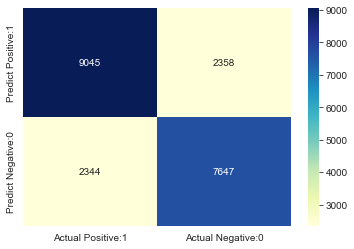

In [35]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     11403
           1       0.76      0.77      0.76      9991

    accuracy                           0.78     21394
   macro avg       0.78      0.78      0.78     21394
weighted avg       0.78      0.78      0.78     21394



In [59]:
TrueText = "Snapchat could become more popular with advertisers than Twitter  Yahoo and AOL within three years  with the messaging app company forecast to be bring in revenues of more than $3bn (£2.4bn) a year by the end of 2019. That bullish forecast is based on advertisers targeting the hard-to-reach youth audience that Snapchat has seemingly cornered. More than half (51%) of video users on the app are under 24  compared with 23% for Facebook and 17% for Google's YouTube (17%)  according to Ampere Analysis. Brands are also keen to see a true rival emerge to challenge Facebook and Google  which have recently come in for heavy criticism for their advertising practices. The two web giants currently account for 58% of the $141bn global mobile ad market."

In [38]:
FakeText = "Yahoo and AOL could be extremely popular over the next decade and revenues are expected to skyrocket by 2020.  This forecast is based on the advertisers that target a younger audience.  Half of the users are under the age of 30 compared to facebook and google which cover the older market, as per the recent analysis posting by the Washington Post.  Facebook and google will be challenged.  The current advertising practices have received extreme criticism, the web giants currently hold a 50% stake in the global ad market and are currently seeing a small decline in their users."

In [39]:
testDF = pd.DataFrame(columns=['text', 'uniqe_words_ratio', 'nounPolarity', 'nounSubjectivity',
                               'sentencePolarity', 'sentenceSubjectivity', 'meanPolarity_per_sentence',
                               'meanSubjetivity_per_sentence', 'Anger', 'Anticipation', 'Disgust',
                               'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'MaxPolarityFrequency',
                               'MaxSubjectivityFrequency', 'corrP', 'corrS', 'entropy'])

In [67]:
testDF.at[0,'text'] = TrueText
construct_Features(range(1),testDF,correct=True)

In [62]:
testDF

text uniqe_words_ratio  \
0  Snapchat could become more popular with advert...          0.746032   

  nounPolarity nounSubjectivity sentencePolarity sentenceSubjectivity  \
0    -0.011111         0.027778         0.208333             0.436667   

  meanPolarity_per_sentence meanSubjetivity_per_sentence Anger Anticipation  \
0                      0.15                     0.326667     3            5   

   ... Fear Joy Sadness Surprise Trust MaxPolarityFrequency  \
0  ...    2   1       1        1     3                10.08   

  MaxSubjectivityFrequency     corrP     corrS  entropy  
0                    10.08  0.785067  0.872082  4.41003  

[1 rows x 21 columns]

In [68]:
model2.predict(testDF.drop(['text'],axis=1).astype(float))[0] # Shall be True (1)

1

In [64]:
testDF.at[0,'text'] = FakeText
construct_Features(range(1),testDF,correct=True)

In [69]:
model2.predict(testDF.drop(['text'],axis=1).astype(float))[0] # Shall be False (0)

1

In [ ]:
# save
import joblib
joblib.dump(model, "model.pkl")

In [ ]:
# load
import joblib
model = joblib.load("model.pkl")

In [74]:
df.describe()

class  uniqe_words_ratio  nounPolarity  nounSubjectivity  \
count  71313.000000       71313.000000  71313.000000      71313.000000   
mean       0.472144           0.586969      0.008379          0.071998   
std        0.499227           0.124181      0.029445          0.049051   
min        0.000000           0.119300     -0.666667          0.000000   
25%        0.000000           0.503987     -0.002520          0.041548   
50%        0.000000           0.570447      0.006271          0.065554   
75%        1.000000           0.651163      0.019269          0.093757   
max        1.000000           1.000000      1.000000          1.000000   

       sentencePolarity  sentenceSubjectivity  meanPolarity_per_sentence  \
count      71313.000000          71313.000000               71313.000000   
mean           0.061845              0.414861                   0.048257   
std            0.107809              0.111237                   0.085864   
min           -1.000000              0.013333                  -0.660714   
25%            0.009115              0.352399                   0.003390   
50%            0.062591              0.416705                   0.047854   
75%            0.114953              0.477727                   0.091898   
max            1.000000              1.000000                   0.875000   

       meanSubjetivity_per_sentence         Anger  Anticipation  ...  \
count                  71313.000000  71313.000000  71313.000000  ...   
mean                       0.320716      8.328846      9.997841  ...   
std                        0.106931     11.472389     13.188583  ...   
min                        0.003509      0.000000      0.000000  ...   
25%                        0.254510      2.000000      3.000000  ...   
50%                        0.317765      5.000000      7.000000  ...   
75%                        0.383070     11.000000     13.000000  ...   
max                        0.975000    350.000000    551.000000  ...   

               Fear           Joy       Sadness      Surprise         Trust  \
count  71313.000000  71313.000000  71313.000000  71313.000000  71313.000000   
mean      10.853028      6.627263      7.454559      4.378641     16.174120   
std       15.307628      9.852127     10.639311      6.337325     20.235218   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      1.000000      2.000000      1.000000      5.000000   
50%        7.000000      4.000000      5.000000      3.000000     11.000000   
75%       14.000000      8.000000     10.000000      6.000000     21.000000   
max      554.000000    458.000000    445.000000    278.000000    809.000000   

       MaxPolarityFrequency  MaxSubjectivityFrequency         corrP  \
count          71313.000000              71313.000000  71313.000000   
mean              10.986576                 10.986576      0.196967   
std                5.010739                  5.010739      0.485992   
min                0.000000                  0.000000     -1.000000   
25%                8.890000                  8.890000     -0.080628   
50%               11.080000                 11.080000      0.243207   
75%               13.200000                 13.200000      0.532121   
max              144.120000                144.120000      1.000000   

              corrS       entropy  
count  71313.000000  71313.000000  
mean       0.218784      4.922401  
std        0.456032      0.610807  
min       -1.000000      1.098612  
25%       -0.007042      4.653267  
50%        0.259437      5.032126  
75%        0.500000      5.319263  
max        1.000000      6.958120  

[8 rows x 21 columns]

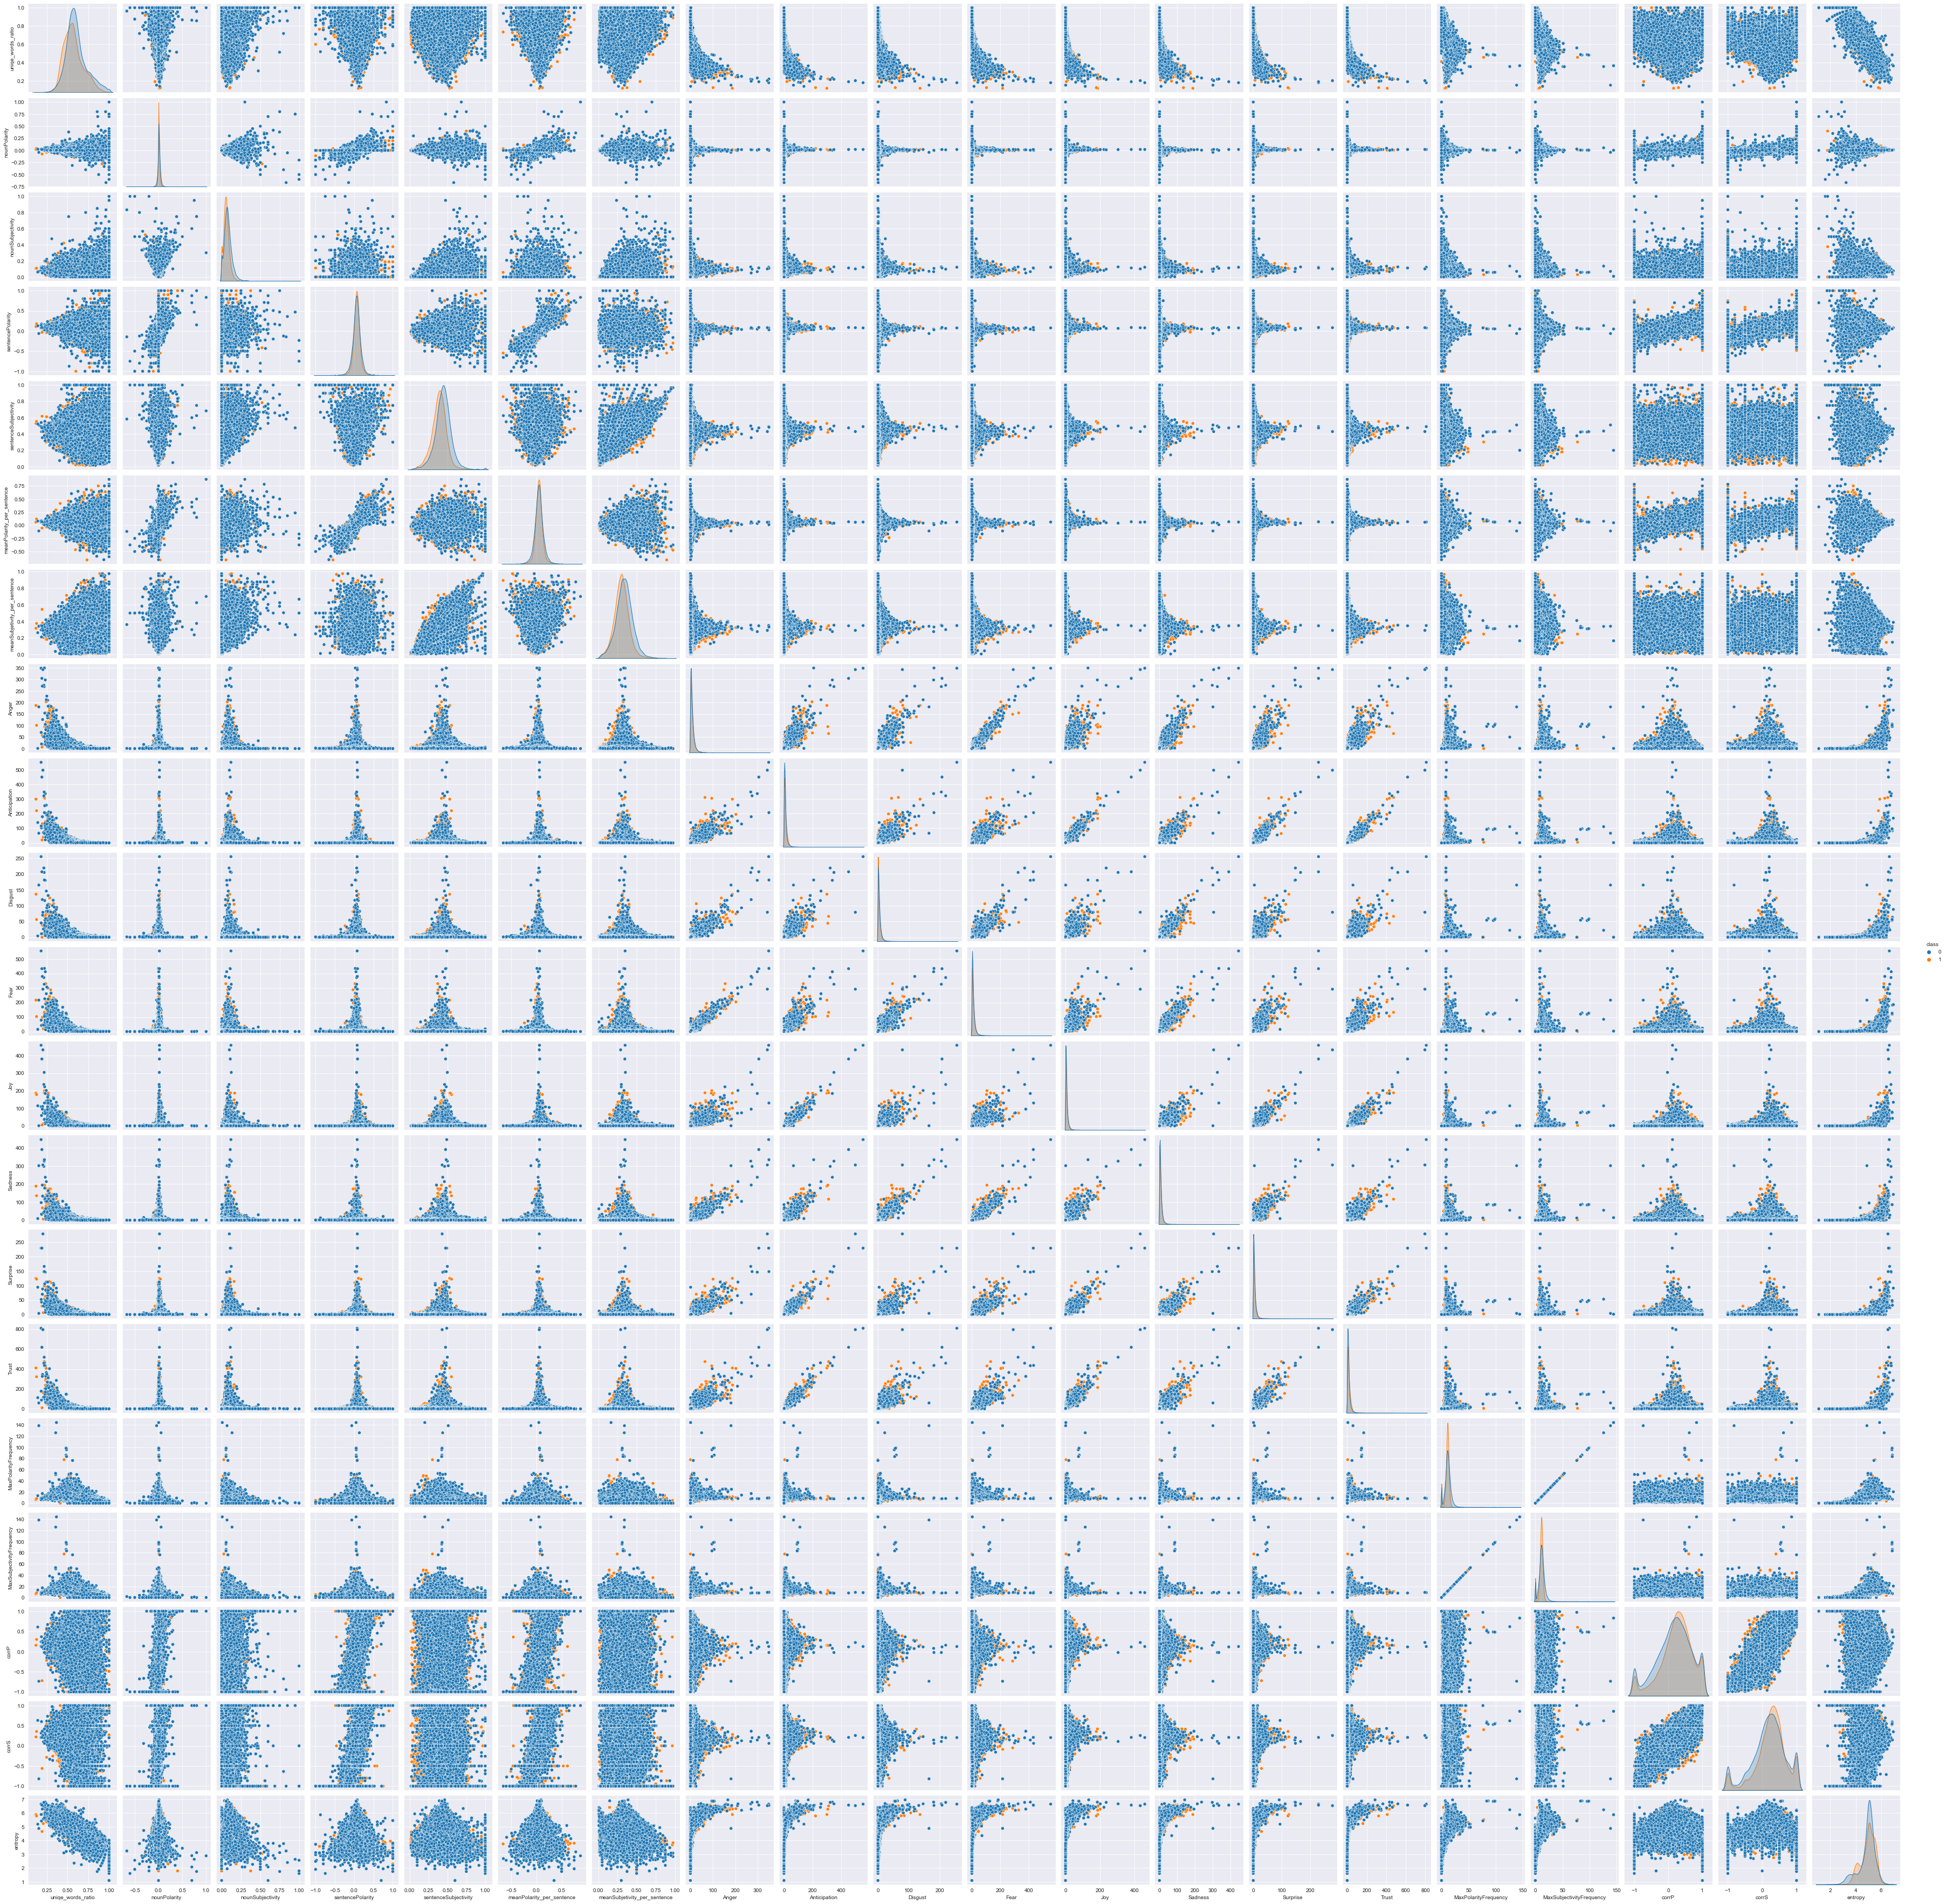

In [75]:
sns.pairplot(df, hue='class', size=2.5);